In [78]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import kornia.augmentation as K

# chunked files from pyspark
folder = "C:/Users/winston/Desktop/preprocessed_npy"
image_chunks = sorted([f for f in os.listdir(folder) if f.startswith("images_chunk")])
label_chunks = sorted([f for f in os.listdir(folder) if f.startswith("labels_chunk")])

# combine chunks
images_all, labels_all = [], []
for img_file, lbl_file in zip(image_chunks, label_chunks):
    images_all.append(np.load(os.path.join(folder, img_file)))
    labels_all.append(np.load(os.path.join(folder, lbl_file)))

images = np.concatenate(images_all, axis=0)
labels = np.concatenate(labels_all, axis=0)

# redo labels: 0 = normal, 1 = covid
new_labels = []
for i in range(len(labels)):
    if(labels[i]==1):
        new_labels.append(0)
    elif(labels[i]==0):
        new_labels.append(1)
    else:
        new_labels.append(labels[i])
        
# label encoding + weights for balancing
labels_encoded = new_labels
weights = compute_class_weight("balanced", classes=np.unique(labels_encoded), y=labels_encoded)
num_classes = len(np.unique(labels))
weights_tensor = torch.tensor(weights, dtype=torch.float32)

# 80% train, 10% validation, 10% test
X_temp, X_val, y_temp, y_val = train_test_split(images, new_labels, test_size=0.15, stratify=new_labels)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.15, stratify=y_temp)

# convert to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# torch datasets + loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, pin_memory=True)

# augmentation w/ kornia
augmenter = nn.Sequential(
    K.RandomHorizontalFlip(p=0.5),
    K.RandomRotation(degrees=10.0),
    K.RandomAffine(degrees=0.0, translate=(0.1, 0.1))
).to("cuda")

# CNN model
class DeepCNN6(nn.Module):
    def __init__(self, num_classes):
        super(DeepCNN6, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Output: (32, H/2, W/2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Output: (64, H/4, W/4)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output: (128, 1, 1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                 # Output: (B, 128)
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x


# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = torch.tensor([0.], device=device)

model = DeepCNN6(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)  # <-- reset to 0.001

# NEW: Add scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True,
    min_lr=1e-6
)

best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(50):
    start = time.time()

    model.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = augmenter(inputs)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct / total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # NEW: Print current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} | LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Time: {time.time() - start:.2f}s")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model.")

    # NOW step the scheduler
    scheduler.step(avg_val_loss)  # <-- put here

Epoch 1 | LR: 0.001000 | Train Loss: 0.8597 | Val Loss: 1.6885 | Val Acc: 0.3271 | Time: 27.38s
Saved best model.
Epoch 2 | LR: 0.001000 | Train Loss: 0.6654 | Val Loss: 0.9110 | Val Acc: 0.6635 | Time: 24.71s
Saved best model.
Epoch 3 | LR: 0.001000 | Train Loss: 0.5938 | Val Loss: 0.6823 | Val Acc: 0.7062 | Time: 25.65s
Saved best model.
Epoch 4 | LR: 0.001000 | Train Loss: 0.5530 | Val Loss: 0.7790 | Val Acc: 0.7012 | Time: 25.78s
Epoch 5 | LR: 0.001000 | Train Loss: 0.5255 | Val Loss: 0.6617 | Val Acc: 0.7033 | Time: 25.39s
Saved best model.
Epoch 6 | LR: 0.001000 | Train Loss: 0.5178 | Val Loss: 0.5071 | Val Acc: 0.7533 | Time: 25.06s
Saved best model.
Epoch 7 | LR: 0.001000 | Train Loss: 0.4994 | Val Loss: 1.5158 | Val Acc: 0.4971 | Time: 25.35s
Epoch 8 | LR: 0.001000 | Train Loss: 0.4977 | Val Loss: 0.9568 | Val Acc: 0.7200 | Time: 25.40s
Epoch 9 | LR: 0.001000 | Train Loss: 0.4838 | Val Loss: 0.6471 | Val Acc: 0.7583 | Time: 24.94s
Epoch 10 | LR: 0.001000 | Train Loss: 0.4677 |

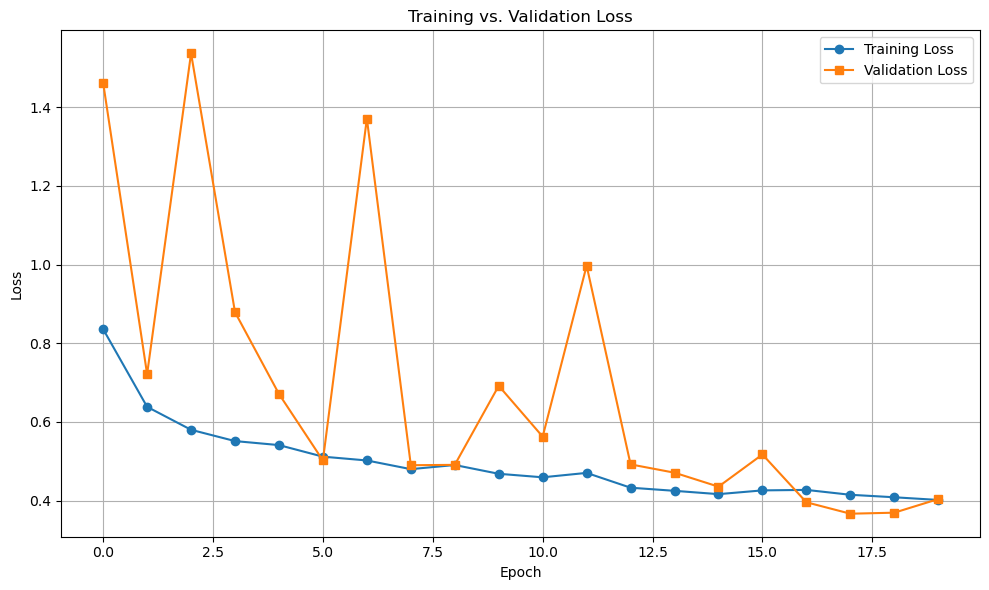

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [75]:
from torchsummary import summary

summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

In [76]:
from sklearn.metrics import classification_report

# evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(targets.numpy())

# classification report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(c) for c in np.unique(new_labels)]))


 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       417
           1       0.92      0.99      0.95       163
           2       0.78      0.73      0.75       383
           3       0.53      0.55      0.54       211

    accuracy                           0.81      1174
   macro avg       0.79      0.80      0.80      1174
weighted avg       0.81      0.81      0.81      1174



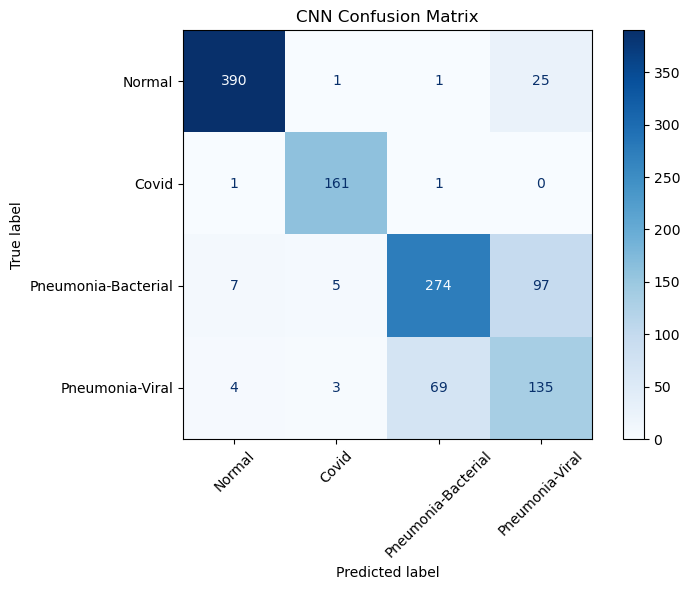

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the best saved model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Replace with your actual label names if needed
label_names = ['Normal', 'Covid', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("CNN Confusion Matrix")
plt.tight_layout()
plt.show()
